In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import time, datetime, calendar, pytz, glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

In [2]:
# runname1 = 'wrf381_control_201?'
# runname2 = 'wrf381_irrig_201?'
# obs_path = '/global/project/projectdirs/m1657/zfeng/usa/nmq/stats/'
# wrf1_path = f'/global/project/projectdirs/m1657/zfeng/usa/wrf/{runname1}/statstb/'
# wrf2_path = f'/global/project/projectdirs/m1657/zfeng/usa/wrf/{runname2}/statstb/'
datadir = '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig3/'

# obs_files = sorted(glob.glob(f'{obs_path}robust_mcs_tracks_*nc'))
# wrf1_files = sorted(glob.glob(f'{wrf1_path}robust_mcs_tracks_*nc'))
# wrf2_files = sorted(glob.glob(f'{wrf2_path}robust_mcs_tracks_*nc'))
obs_files = sorted(glob.glob(f'{datadir}nmq_robust_mcs_tracks_*nc'))
wrf1_files = sorted(glob.glob(f'{datadir}wrf_control_robust_mcs_tracks_*nc'))
wrf2_files = sorted(glob.glob(f'{datadir}wrf_irrig_robust_mcs_tracks_*nc'))

# figdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/results/'
# figdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/figures4paper/'
figdir = datadir

In [3]:
obs_files, wrf1_files, wrf2_files

(['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig3/nmq_robust_mcs_tracks_20110401_20111031.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig3/nmq_robust_mcs_tracks_20120401_20121031.nc'],
 ['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig3/wrf_control_robust_mcs_tracks_20110401_20111031.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig3/wrf_control_robust_mcs_tracks_20120401_20121031.nc'],
 ['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig3/wrf_irrig_robust_mcs_tracks_20110401_20111031.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig3/wrf_irrig_robust_mcs_tracks_20120401_20121031.nc'])

In [4]:
dsobs = xr.open_mfdataset(obs_files, concat_dim='tracks', combine='nested', drop_variables=['mergecloudnumber','splitcloudnumber']).load()
# Replace the tracks coordinate with monotonically increased one
dsobs['tracks'] = np.arange(0, dsobs.sizes['tracks'], 1)
# Take first time of each track and add it as a new coordinate
starttime = dsobs.base_time.isel(times=0).drop('times')
dsobs.coords['starttime'] = starttime
# dsobs

In [5]:
dswrf1 = xr.open_mfdataset(wrf1_files, concat_dim='tracks', combine='nested', drop_variables=['mergecloudnumber','splitcloudnumber']).load()
# Replace the tracks coordinate with monotonically increased one
dswrf1['tracks'] = np.arange(0, dswrf1.sizes['tracks'], 1)
# Take first time of each track and add it as a new coordinate
starttime = dswrf1.base_time.isel(times=0).drop('times')
dswrf1.coords['starttime'] = starttime
# dswrf1

In [6]:
dswrf2 = xr.open_mfdataset(wrf2_files, concat_dim='tracks', combine='nested', drop_variables=['mergecloudnumber','splitcloudnumber']).load()
# Replace the tracks coordinate with monotonically increased one
dswrf2['tracks'] = np.arange(0, dswrf2.sizes['tracks'], 1)
# Take first time of each track and add it as a new coordinate
starttime = dswrf2.base_time.isel(times=0).drop('times')
dswrf2.coords['starttime'] = starttime
# dswrf2

In [7]:
def find_track_in_region(pf_lon, pf_lat, pf_length, startresult, lonbox, latbox):
    """
    A function to select tracks in a certain region.
    """
    
    # Create an array for storing track index
    ntracks = pf_lon.sizes['tracks']
    trackidx = np.ones(ntracks, dtype=int)*-99

    # Ignore RuntimeWarnings in this block of code
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Loop over each track
        for ii in range(0, ntracks):
            # Find lat/lon within the box
            idx = np.where((pf_lon[ii,:] >= lonbox[0]) & (pf_lon[ii,:] <= lonbox[1]) & 
                           (pf_lat[ii,:] >= latbox[0]) & (pf_lat[ii,:] <= latbox[1]))
            # If MCS spends more than half of its lifetime in the box, 
            # and MCS is not a split (startresult != 13)
            if ((np.count_nonzero(idx) >= pf_length[ii]*0.5) & \
                (starttrackresult[ii] != 13)):
                trackidx[ii] = ii
    #         print(ii, np.count_nonzero(idx))

    # Filter tracks that are not in the box
    mcsidx = trackidx[trackidx != -99]
    nmcs_obs = len(mcsidx)
    print('Number of MCS:', nmcs_obs)
    return mcsidx

In [8]:
pf_lon = dsobs.pf_lon.isel(nmaxpf=0)
pf_lat = dsobs.pf_lat.isel(nmaxpf=0)
pf_length = dsobs.pf_length
starttrackresult = dsobs.starttrackresult

# Define a region to select MCSs
# lonbox = [-105,-83]
# latbox = [37,49]
lonbox = [-105,-83]
latbox = [36,45]

mcsidx_obs = find_track_in_region(pf_lon, pf_lat,pf_length, starttrackresult, lonbox, latbox)

Number of MCS: 174


In [9]:
pf_lon = dswrf1.pf_lon.isel(nmaxpf=0)
pf_lat = dswrf1.pf_lat.isel(nmaxpf=0)
pf_length = dswrf1.pf_length
starttrackresult = dswrf1.starttrackresult

mcsidx_wrf1 = find_track_in_region(pf_lon, pf_lat,pf_length, starttrackresult, lonbox, latbox)

Number of MCS: 93


In [10]:
pf_lon = dswrf2.pf_lon.isel(nmaxpf=0)
pf_lat = dswrf2.pf_lat.isel(nmaxpf=0)
pf_length = dswrf2.pf_length
starttrackresult = dswrf2.starttrackresult

mcsidx_wrf2 = find_track_in_region(pf_lon, pf_lat,pf_length, starttrackresult, lonbox, latbox)

Number of MCS: 118


In [11]:
ntracks_obs = len(mcsidx_obs)
ntracks_wrf1 = len(mcsidx_wrf1)
ntracks_wrf2 = len(mcsidx_wrf2)

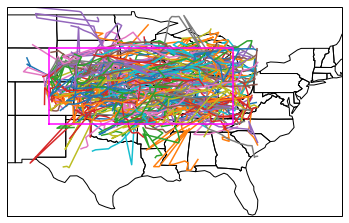

In [12]:
# Plot the tracks on the map to double check if the region selection is working
pf_lon_obs = dsobs.pf_lon.isel(nmaxpf=0, tracks=mcsidx_obs)
pf_lat_obs = dsobs.pf_lat.isel(nmaxpf=0, tracks=mcsidx_obs)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-110,-70,25,50], crs=ccrs.PlateCarree())
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '110m')
ax.add_feature(states, edgecolor='k', facecolor='none')

for it in range(0, ntracks_obs):
    plt.plot(pf_lon_obs[it,:], pf_lat_obs[it,:], transform=ccrs.PlateCarree())
    
plt.plot([lonbox[0],lonbox[1],lonbox[1],lonbox[0],lonbox[0]], [latbox[0],latbox[0],latbox[1],latbox[1],latbox[0]], 
         color='magenta', transform=ccrs.PlateCarree())

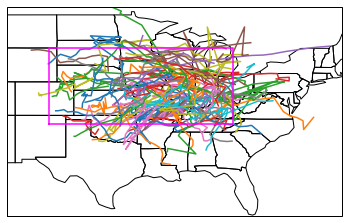

In [13]:
# Plot the tracks on the map to double check if the region selection is working
pf_lon_wrf1 = dswrf1.pf_lon.isel(nmaxpf=0, tracks=mcsidx_wrf1)
pf_lat_wrf1 = dswrf1.pf_lat.isel(nmaxpf=0, tracks=mcsidx_wrf1)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-110,-70,25,50], crs=ccrs.PlateCarree())
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '110m')
ax.add_feature(states, edgecolor='k', facecolor='none')

for it in range(0, ntracks_wrf1):
    plt.plot(pf_lon_wrf1[it,:], pf_lat_wrf1[it,:], transform=ccrs.PlateCarree())
    
plt.plot([lonbox[0],lonbox[1],lonbox[1],lonbox[0],lonbox[0]], [latbox[0],latbox[0],latbox[1],latbox[1],latbox[0]], 
         color='magenta', transform=ccrs.PlateCarree())

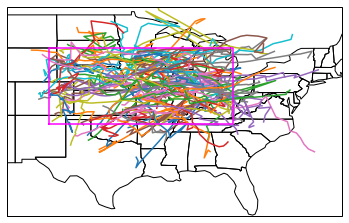

In [14]:
# Plot the tracks on the map to double check if the region selection is working
pf_lon_wrf2 = dswrf2.pf_lon.isel(nmaxpf=0, tracks=mcsidx_wrf2)
pf_lat_wrf2 = dswrf2.pf_lat.isel(nmaxpf=0, tracks=mcsidx_wrf2)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-110,-70,25,50], crs=ccrs.PlateCarree())
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '110m')
ax.add_feature(states, edgecolor='k', facecolor='none')

for it in range(0, ntracks_wrf2):
    plt.plot(pf_lon_wrf2[it,:], pf_lat_wrf2[it,:], transform=ccrs.PlateCarree())
    
plt.plot([lonbox[0],lonbox[1],lonbox[1],lonbox[0],lonbox[0]], [latbox[0],latbox[0],latbox[1],latbox[1],latbox[0]], 
         color='magenta', transform=ccrs.PlateCarree())

In [15]:
stime_obs = dsobs.base_time.isel(times=0, tracks=mcsidx_obs)
syear_obs = stime_obs.dt.year
smonth_obs = stime_obs.dt.month

lifetime_obs_jja = dsobs.pf_length.isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
mcsstatus_obs_jja = dsobs.pf_mcsstatus.isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfarea_obs_jja = dsobs.pf_area.isel(tracks=mcsidx_obs, nmaxpf=0).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfccarea_obs_jja = dsobs.pf_ccarea.isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfsfarea_obs_jja = dsobs.pf_sfarea.isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfrainrate_obs_jja = dsobs.pf_rainrate.isel(tracks=mcsidx_obs, nmaxpf=0).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfvolrain_obs_jja = ((dsobs.pf_ccvolrate + dsobs.pf_sfvolrate) * 16).isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfccvolrain_obs_jja = (dsobs.pf_ccvolrate * 16).isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfsfvolrain_obs_jja = (dsobs.pf_sfvolrate * 16).isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
pfdiam_obs_jja = np.sqrt(4*dsobs.pf_area/np.pi).isel(tracks=mcsidx_obs, nmaxpf=0).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
coremaxdbz40_obs_jja = dsobs.pf_coremaxdbz40.isel(tracks=mcsidx_obs).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)
corediam_obs_jja = np.sqrt(4*dsobs.pf_corearea/np.pi).isel(tracks=mcsidx_obs, nmaxcore=0).where((smonth_obs >= 6) & (smonth_obs <= 8), drop=True)

In [16]:
stime_wrf1 = dswrf1.base_time.isel(times=0, tracks=mcsidx_wrf1)
syear_wrf1 = stime_wrf1.dt.year
smonth_wrf1 = stime_wrf1.dt.month

lifetime_wrf1_jja = dswrf1.pf_length.isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
mcsstatus_wrf1_jja = dswrf1.pf_mcsstatus.isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfarea_wrf1_jja = dswrf1.pf_area.isel(tracks=mcsidx_wrf1, nmaxpf=0).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfccarea_wrf1_jja = dswrf1.pf_ccarea.isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfsfarea_wrf1_jja = dswrf1.pf_sfarea.isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfrainrate_wrf1_jja = dswrf1.pf_rainrate.isel(tracks=mcsidx_wrf1, nmaxpf=0).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfvolrain_wrf1_jja = ((dswrf1.pf_ccvolrate + dswrf1.pf_sfvolrate) * 16).isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfccvolrain_wrf1_jja = (dswrf1.pf_ccvolrate * 16).isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfsfvolrain_wrf1_jja = (dswrf1.pf_sfvolrate * 16).isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
pfdiam_wrf1_jja = np.sqrt(4*dswrf1.pf_area/np.pi).isel(tracks=mcsidx_wrf1, nmaxpf=0).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
coremaxdbz40_wrf1_jja = dswrf1.pf_coremaxdbz40.isel(tracks=mcsidx_wrf1).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)
corediam_wrf1_jja = np.sqrt(4*dswrf1.pf_corearea/np.pi).isel(tracks=mcsidx_wrf1, nmaxcore=0).where((smonth_wrf1 >= 6) & (smonth_wrf1 <= 8), drop=True)

In [17]:
stime_wrf2 = dswrf2.base_time.isel(times=0, tracks=mcsidx_wrf2)
syear_wrf2 = stime_wrf2.dt.year
smonth_wrf2 = stime_wrf2.dt.month

lifetime_wrf2_jja = dswrf2.pf_length.isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
mcsstatus_wrf2_jja = dswrf2.pf_mcsstatus.isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfarea_wrf2_jja = dswrf2.pf_area.isel(tracks=mcsidx_wrf2, nmaxpf=0).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfccarea_wrf2_jja = dswrf2.pf_ccarea.isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfsfarea_wrf2_jja = dswrf2.pf_sfarea.isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfrainrate_wrf2_jja = dswrf2.pf_rainrate.isel(tracks=mcsidx_wrf2, nmaxpf=0).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfvolrain_wrf2_jja = ((dswrf2.pf_ccvolrate + dswrf2.pf_sfvolrate) * 16).isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfccvolrain_wrf2_jja = (dswrf2.pf_ccvolrate * 16).isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfsfvolrain_wrf2_jja = (dswrf2.pf_sfvolrate * 16).isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
pfdiam_wrf2_jja = np.sqrt(4*dswrf2.pf_area/np.pi).isel(tracks=mcsidx_wrf2, nmaxpf=0).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
coremaxdbz40_wrf2_jja = dswrf2.pf_coremaxdbz40.isel(tracks=mcsidx_wrf2).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)
corediam_wrf2_jja = np.sqrt(4*dswrf2.pf_corearea/np.pi).isel(tracks=mcsidx_wrf2, nmaxcore=0).where((smonth_wrf2 >= 6) & (smonth_wrf2 <= 8), drop=True)

In [18]:
nmcs_obs_jja = len(lifetime_obs_jja)
nmcs_wrf1_jja = len(lifetime_wrf1_jja)
nmcs_wrf2_jja = len(lifetime_wrf2_jja)
print(nmcs_obs_jja, nmcs_wrf1_jja, nmcs_wrf2_jja)

95 38 63


In [19]:
life_bins = np.arange(6, 45.1, 3)
binrange = (0, 45)
pdf_lifetime_obs_jja, bins = np.histogram(lifetime_obs_jja, bins=life_bins, range=binrange, density=True)
hist_lifetime_obs_jja, bins = np.histogram(lifetime_obs_jja, bins=life_bins, range=binrange, density=False)

pdf_lifetime_wrf1_jja, bins = np.histogram(lifetime_wrf1_jja, bins=life_bins, range=binrange, density=True)
hist_lifetime_wrf1_jja, bins = np.histogram(lifetime_wrf1_jja, bins=life_bins, range=binrange, density=False)

pdf_lifetime_wrf2_jja, bins = np.histogram(lifetime_wrf2_jja, bins=life_bins, range=binrange, density=True)
hist_lifetime_wrf2_jja, bins = np.histogram(lifetime_wrf2_jja, bins=life_bins, range=binrange, density=False)

In [20]:
# Parameters are selected during MCS stage (mcsstatus==1)
pfdiam_bins = np.arange(0,600.1,50)
binrange = (0,600)
pdf_pfdiam_obs_jja, bins = np.histogram(pfdiam_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfdiam_bins, range=binrange, density=True)
hist_pfdiam_obs_jja, bins = np.histogram(pfdiam_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfdiam_bins, range=binrange, density=False)

pdf_pfdiam_wrf1_jja, bins = np.histogram(pfdiam_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfdiam_bins, range=binrange, density=True)
hist_pfdiam_wrf1_jja, bins = np.histogram(pfdiam_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfdiam_bins, range=binrange, density=False)

pdf_pfdiam_wrf2_jja, bins = np.histogram(pfdiam_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfdiam_bins, range=binrange, density=True)
hist_pfdiam_wrf2_jja, bins = np.histogram(pfdiam_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfdiam_bins, range=binrange, density=False)

In [21]:
# Parameters are selected during MCS stage (mcsstatus==1)
pfrainrate_bins = np.arange(1,20.1,1)
binrange = (0,20)
pdf_pfrainrate_obs_jja, bins = np.histogram(pfrainrate_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfrainrate_bins, range=binrange, density=True)
hist_pfrainrate_obs_jja, bins = np.histogram(pfrainrate_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfrainrate_bins, range=binrange, density=False)

pdf_pfrainrate_wrf1_jja, bins = np.histogram(pfrainrate_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfrainrate_bins, range=binrange, density=True)
hist_pfrainrate_wrf1_jja, bins = np.histogram(pfrainrate_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfrainrate_bins, range=binrange, density=False)

pdf_pfrainrate_wrf2_jja, bins = np.histogram(pfrainrate_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfrainrate_bins, range=binrange, density=True)
hist_pfrainrate_wrf2_jja, bins = np.histogram(pfrainrate_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfrainrate_bins, range=binrange, density=False)

In [22]:
# Parameters are selected during MCS stage (mcsstatus==1)
pfvolrain_bins = np.arange(0,1500000.1,100000)
binrange = (0,1500000)
pdf_pfvolrain_obs_jja, bins = np.histogram(pfvolrain_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfvolrain_bins, range=binrange, density=True)
hist_pfvolrain_obs_jja, bins = np.histogram(pfvolrain_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfvolrain_bins, range=binrange, density=False)

pdf_pfvolrain_wrf1_jja, bins = np.histogram(pfvolrain_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfvolrain_bins, range=binrange, density=True)
hist_pfvolrain_wrf1_jja, bins = np.histogram(pfvolrain_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfvolrain_bins, range=binrange, density=False)

pdf_pfvolrain_wrf2_jja, bins = np.histogram(pfvolrain_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfvolrain_bins, range=binrange, density=True)
hist_pfvolrain_wrf2_jja, bins = np.histogram(pfvolrain_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfvolrain_bins, range=binrange, density=False)

In [23]:
# Parameters are selected during MCS stage (mcsstatus==1)
pfccvolrain_bins = np.arange(0,500000.1,50000)
binrange = (0,500000)
pdf_pfccvolrain_obs_jja, bins = np.histogram(pfccvolrain_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfccvolrain_bins, range=binrange, density=True)
hist_pfccvolrain_obs_jja, bins = np.histogram(pfccvolrain_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfccvolrain_bins, range=binrange, density=False)

pdf_pfccvolrain_wrf1_jja, bins = np.histogram(pfccvolrain_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfccvolrain_bins, range=binrange, density=True)
hist_pfccvolrain_wrf1_jja, bins = np.histogram(pfccvolrain_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfccvolrain_bins, range=binrange, density=False)

pdf_pfccvolrain_wrf2_jja, bins = np.histogram(pfccvolrain_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfccvolrain_bins, range=binrange, density=True)
hist_pfccvolrain_wrf2_jja, bins = np.histogram(pfccvolrain_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfccvolrain_bins, range=binrange, density=False)

In [24]:
# Parameters are selected during MCS stage (mcsstatus==1)
pfsfvolrain_bins = np.arange(0,1000000.1,100000)
binrange = (0,1000000)
pdf_pfsfvolrain_obs_jja, bins = np.histogram(pfsfvolrain_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfsfvolrain_bins, range=binrange, density=True)
hist_pfsfvolrain_obs_jja, bins = np.histogram(pfsfvolrain_obs_jja.where(mcsstatus_obs_jja == 1), bins=pfsfvolrain_bins, range=binrange, density=False)

pdf_pfsfvolrain_wrf1_jja, bins = np.histogram(pfsfvolrain_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfsfvolrain_bins, range=binrange, density=True)
hist_pfsfvolrain_wrf1_jja, bins = np.histogram(pfsfvolrain_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=pfsfvolrain_bins, range=binrange, density=False)

pdf_pfsfvolrain_wrf2_jja, bins = np.histogram(pfsfvolrain_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfsfvolrain_bins, range=binrange, density=True)
hist_pfsfvolrain_wrf2_jja, bins = np.histogram(pfsfvolrain_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=pfsfvolrain_bins, range=binrange, density=False)

In [25]:
# Parameters are selected during MCS stage (mcsstatus==1)
coremaxdbz40_bins = np.arange(0,20.1,1)
binrange = (0,20)
pdf_coremaxdbz40_obs_jja, bins = np.histogram(coremaxdbz40_obs_jja.where(mcsstatus_obs_jja == 1), bins=coremaxdbz40_bins, range=binrange, density=True)
hist_coremaxdbz40_obs_jja, bins = np.histogram(coremaxdbz40_obs_jja.where(mcsstatus_obs_jja == 1), bins=coremaxdbz40_bins, range=binrange, density=False)

pdf_coremaxdbz40_wrf1_jja, bins = np.histogram(coremaxdbz40_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=coremaxdbz40_bins, range=binrange, density=True)
hist_coremaxdbz40_wrf1_jja, bins = np.histogram(coremaxdbz40_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=coremaxdbz40_bins, range=binrange, density=False)

pdf_coremaxdbz40_wrf2_jja, bins = np.histogram(coremaxdbz40_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=coremaxdbz40_bins, range=binrange, density=True)
hist_coremaxdbz40_wrf2_jja, bins = np.histogram(coremaxdbz40_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=coremaxdbz40_bins, range=binrange, density=False)

In [26]:
# Parameters are selected during MCS stage (mcsstatus==1)
corediam_bins = np.arange(0,200.1,10)
binrange = (0,200)
pdf_corediam_obs_jja, bins = np.histogram(corediam_obs_jja.where(mcsstatus_obs_jja == 1), bins=corediam_bins, range=binrange, density=True)
hist_corediam_obs_jja, bins = np.histogram(corediam_obs_jja.where(mcsstatus_obs_jja == 1), bins=corediam_bins, range=binrange, density=False)

pdf_corediam_wrf1_jja, bins = np.histogram(corediam_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=corediam_bins, range=binrange, density=True)
hist_corediam_wrf1_jja, bins = np.histogram(corediam_wrf1_jja.where(mcsstatus_wrf1_jja == 1), bins=corediam_bins, range=binrange, density=False)

pdf_corediam_wrf2_jja, bins = np.histogram(corediam_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=corediam_bins, range=binrange, density=True)
hist_corediam_wrf2_jja, bins = np.histogram(corediam_wrf2_jja.where(mcsstatus_wrf2_jja == 1), bins=corediam_bins, range=binrange, density=False)

In [27]:
# plt.plot(corediam_bins[:-1], pdf_corediam_obs_jja, 'k', label='OBS')
# plt.plot(corediam_bins[:-1], pdf_corediam_wrf1_jja, 'b', label='CTL')
# plt.plot(corediam_bins[:-1], pdf_corediam_wrf2_jja, 'r', label='IRI')
# plt.legend()

In [28]:
# plt.plot(coremaxdbz40_bins[:-1], pdf_coremaxdbz40_obs_jja, 'k', label='OBS')
# plt.plot(coremaxdbz40_bins[:-1], pdf_coremaxdbz40_wrf1_jja, 'b', label='CTL')
# plt.plot(coremaxdbz40_bins[:-1], pdf_coremaxdbz40_wrf2_jja, 'r', label='IRI')
# plt.legend()

In [29]:
# plt.plot(pfrainrate_bins[:-1], pdf_pfrainrate_obs_jja, 'k', label='OBS')
# plt.plot(pfrainrate_bins[:-1], pdf_pfrainrate_wrf1_jja, 'b', label='CTL')
# plt.plot(pfrainrate_bins[:-1], pdf_pfrainrate_wrf2_jja, 'r', label='IRI')
# plt.legend()

In [30]:
# plt.plot(pfdiam_bins[:-1], pdf_pfdiam_obs_jja, 'k', label='OBS')
# plt.plot(pfdiam_bins[:-1], pdf_pfdiam_wrf1_jja, 'b', label='CTL')
# plt.plot(pfdiam_bins[:-1], pdf_pfdiam_wrf2_jja, 'r', label='IRI')
# plt.legend()

In [31]:
# ax = plt.subplot()
# ax.plot(pfvolrain_bins[:-1]/1e4, pdf_pfvolrain_obs_jja, 'k', label='OBS')
# ax.plot(pfvolrain_bins[:-1]/1e4, pdf_pfvolrain_wrf1_jja, 'b', label='CTL')
# ax.plot(pfvolrain_bins[:-1]/1e4, pdf_pfvolrain_wrf2_jja, 'r', label='IRI')
# ax.set_yscale('log')
# ax.legend()

In [32]:
# ax = plt.subplot()
# ax.plot(pfccvolrain_bins[:-1]/1e4, pdf_pfccvolrain_obs_jja, 'k', label='OBS')
# ax.plot(pfccvolrain_bins[:-1]/1e4, pdf_pfccvolrain_wrf1_jja, 'b', label='CTL')
# ax.plot(pfccvolrain_bins[:-1]/1e4, pdf_pfccvolrain_wrf2_jja, 'r', label='IRI')
# ax.set_yscale('log')
# ax.legend()

In [33]:
# ax = plt.subplot()
# ax.plot(pfsfvolrain_bins[:-1]/1e4, pdf_pfsfvolrain_obs_jja, 'k', label='OBS')
# ax.plot(pfsfvolrain_bins[:-1]/1e4, pdf_pfsfvolrain_wrf1_jja, 'b', label='CTL')
# ax.plot(pfsfvolrain_bins[:-1]/1e4, pdf_pfsfvolrain_wrf2_jja, 'r', label='IRI')
# ax.set_yscale('log')
# ax.legend()

In [34]:
# plt.plot(life_bins[:-1], hist_lifetime_obs_jja, 'k', label='OBS')
# plt.plot(life_bins[:-1], hist_lifetime_wrf1_jja, 'b', label='CTL')
# plt.plot(life_bins[:-1], hist_lifetime_wrf2_jja, 'r', label='IRI')
# plt.legend()

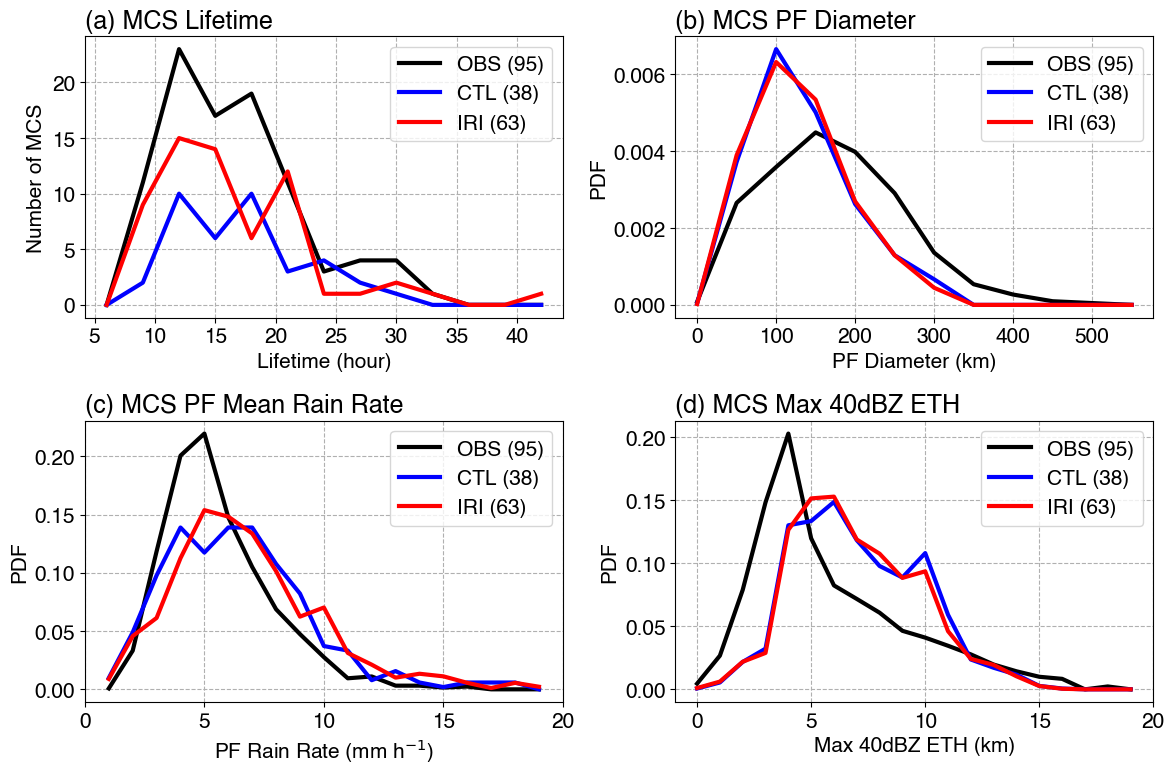

In [35]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.weight'] = 'regular'
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,8], dpi=100)

colors = ['k','b','r']

axes[0,0].plot(life_bins[:-1], hist_lifetime_obs_jja, colors[0], lw=3, label=f'OBS ({nmcs_obs_jja})')
axes[0,0].plot(life_bins[:-1], hist_lifetime_wrf1_jja, colors[1], lw=3, label=f'CTL ({nmcs_wrf1_jja})')
axes[0,0].plot(life_bins[:-1], hist_lifetime_wrf2_jja, colors[2], lw=3, label=f'IRI ({nmcs_wrf2_jja})')
axes[0,0].legend()
axes[0,0].grid(which='major', ls='--')
axes[0,0].set_title('(a) MCS Lifetime', loc='left')
axes[0,0].set_xlabel('Lifetime (hour)')
axes[0,0].set_ylabel('Number of MCS')
axes[0,0].set_xticks(np.arange(5,40.1,5))

axes[0,1].plot(pfdiam_bins[:-1], pdf_pfdiam_obs_jja, colors[0], lw=3, label=f'OBS ({nmcs_obs_jja})')
axes[0,1].plot(pfdiam_bins[:-1], pdf_pfdiam_wrf1_jja, colors[1], lw=3, label=f'CTL ({nmcs_wrf1_jja})')
axes[0,1].plot(pfdiam_bins[:-1], pdf_pfdiam_wrf2_jja, colors[2], lw=3, label=f'IRI ({nmcs_wrf2_jja})')
axes[0,1].legend()
axes[0,1].grid(which='major', ls='--')
axes[0,1].set_title('(b) MCS PF Diameter', loc='left')
axes[0,1].set_xlabel('PF Diameter (km)')
axes[0,1].set_ylabel('PDF')
# axes[0,1].set_xticks(np.arange(0,500.1,100))

axes[1,0].plot(pfrainrate_bins[:-1], pdf_pfrainrate_obs_jja, colors[0], lw=3, label=f'OBS ({nmcs_obs_jja})')
axes[1,0].plot(pfrainrate_bins[:-1], pdf_pfrainrate_wrf1_jja, colors[1], lw=3, label=f'CTL ({nmcs_wrf1_jja})')
axes[1,0].plot(pfrainrate_bins[:-1], pdf_pfrainrate_wrf2_jja, colors[2], lw=3, label=f'IRI ({nmcs_wrf2_jja})')
axes[1,0].legend()
axes[1,0].grid(which='major', ls='--')
axes[1,0].set_title('(c) MCS PF Mean Rain Rate', loc='left')
axes[1,0].set_xlabel('PF Rain Rate (mm h$^{-1}$)')
axes[1,0].set_ylabel('PDF')
axes[1,0].set_xticks(np.arange(0,20.1,5))

axes[1,1].plot(coremaxdbz40_bins[:-1], pdf_coremaxdbz40_obs_jja, colors[0], lw=3, label=f'OBS ({nmcs_obs_jja})')
axes[1,1].plot(coremaxdbz40_bins[:-1], pdf_coremaxdbz40_wrf1_jja, colors[1], lw=3, label=f'CTL ({nmcs_wrf1_jja})')
axes[1,1].plot(coremaxdbz40_bins[:-1], pdf_coremaxdbz40_wrf2_jja, colors[2], lw=3, label=f'IRI ({nmcs_wrf2_jja})')
axes[1,1].legend()
axes[1,1].grid(which='major', ls='--')
axes[1,1].set_title('(d) MCS Max 40dBZ ETH', loc='left')
axes[1,1].set_xlabel('Max 40dBZ ETH (km)')
axes[1,1].set_ylabel('PDF')
axes[1,1].set_xticks(np.arange(0,20.1,5))

fig.tight_layout()
# fig.savefig(f'{figdir}obs_wrf_mcs_trackstats_pdf.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{figdir}obs_wrf_mcs_trackstats_pdf.pdf', dpi=300, bbox_inches='tight')